# DAVIS data analysis notebook

This notebook demonstrates some of the analysis tools I hacked for analysing DAVIS data. These are all collected in the module DIC_analysis.py. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from matplotlib import gridspec
from skimage.transform import radon, rescale, resize,frt2
from skimage.morphology import skeletonize
from skimage import io, color, measure
from scipy.signal import medfilt, find_peaks_cwt
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib inline

## Reading the data in
The class below reads in the data and makes a number of data views available:

In [2]:
class DeformationMap():
    """ A class for importing Davis displacement data with 
    methods for returning deformation maps
    
    Requires: path and filename
    Returns: a deformation map object
    
    Usage:
    
    deformation_map=deformation_map('path','filename')
    
    """
    
    def __init__(self,path,fname) :
        self.path=path
        self.fname=fname
        self.data=np.loadtxt(self.path+self.fname,skiprows=1)
        self.xc=self.data[:,0] #x coordinates
        self.yc=self.data[:,1] #y coordinates
        self.xd=self.data[:,2] #x displacement
        self.yd=self.data[:,3] #y displacement
        
        self.xdim=(self.xc.max()-self.xc.min()
                  )/min(abs((np.diff(self.xc))))+1 #size of map along x
        self.ydim=(self.yc.max()-self.yc.min()
                  )/max(abs((np.diff(self.yc))))+1 #size of map along y
        self.x_map=self._map(self.xd,self.ydim,self.xdim) #u (displacement component along x) 
        self.y_map=self._map(self.yd,self.ydim,self.xdim) #v (displacement component along x) 
        self.f11=self._grad(self.x_map)[1]#f11
        self.f22=self._grad(self.y_map)[0]#f22
        self.f12=self._grad(self.x_map)[0]#f12
        self.f21=self._grad(self.y_map)[1]#f21
        
        self.max_shear=np.sqrt((((self.f11-self.f22)/2.)**2)
                               + ((self.f12+self.f21)/2.)**2)# max shear component
        self.mapshape=np.shape(self.max_shear)
        
    def _map(self,data_col,ydim,xdim):
        data_map=np.reshape(np.array(data_col),(int(ydim),int(xdim)))
        return data_map
    
    def _grad(self,data_map) :
        grad_step=min(abs((np.diff(self.xc))))
        data_grad=np.gradient(data_map,grad_step,grad_step)
        return data_grad

In [3]:
def_map=DeformationMap('../data/','p2-1.txt')

The deformation component maps can then be plotted. The x displacement is given by:

0.0103773587115


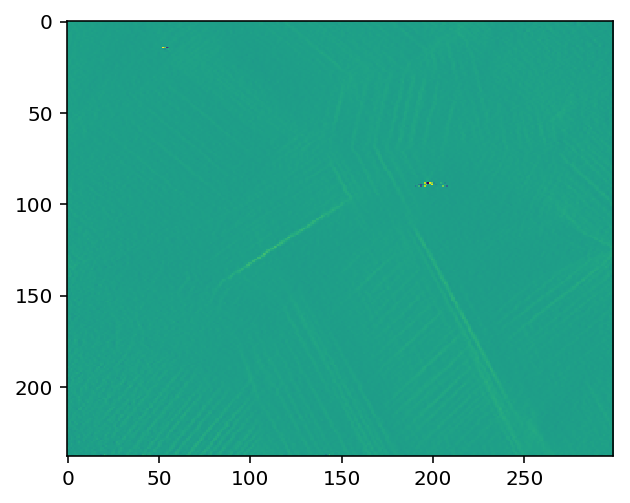

In [4]:

cropped=def_map.f11[:,10:-10]
plt.imshow(cropped,cmap='viridis');
print(np.mean(cropped))

Max shear:

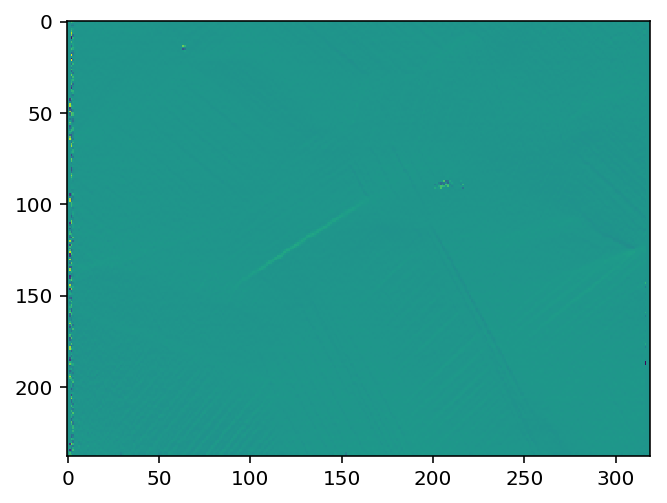

In [5]:
plt.figure()
plt.imshow(def_map.f12,cmap='viridis');

Or on a logarthmic scale:

/Users/joao/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


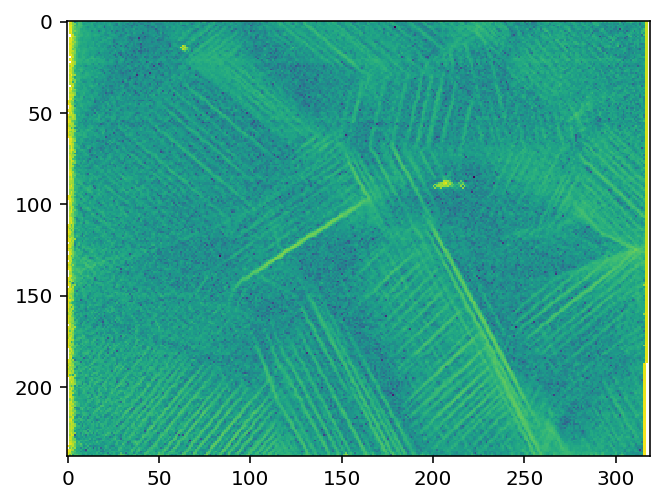

In [6]:
plt.figure()
plt.imshow(np.log(def_map.max_shear),cmap='viridis');

## Data coarsening

Strain can be calculated over any range:

In [7]:
def strain_map_step(xdmap,ydmap,step):
    d_x=np.gradient(xdmap[::step,::step],8*step,8*step)
    d_y=np.gradient(ydmap[::step,::step],8*step,8*step) 
    return d_x,d_y

def coarse_map(step):
    dx,dy=strain_map_step(xmap,ymap,step)
    plt.imshow(dx[1],vmin=-0.00,vmax=0.05,interpolation='none',cmap='viridis');

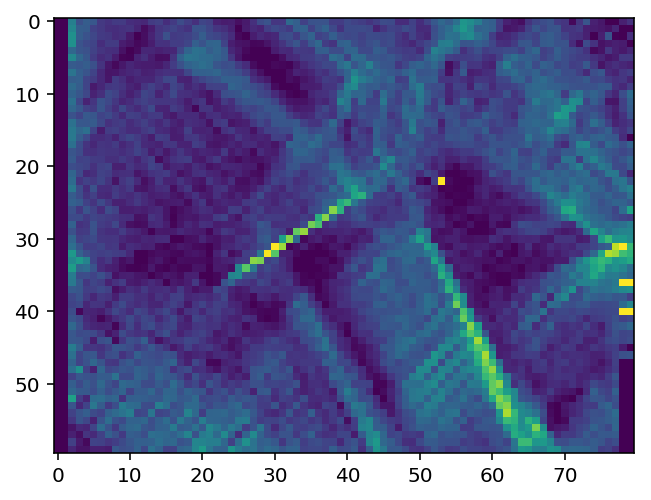

In [8]:
xmap=def_map.x_map
ymap=def_map.y_map
dx,dy=strain_map_step(xmap,ymap,4)
figure=plt.figure()
plt.imshow(dx[1],vmin=-0.00,vmax=0.05,interpolation='none',cmap='viridis');

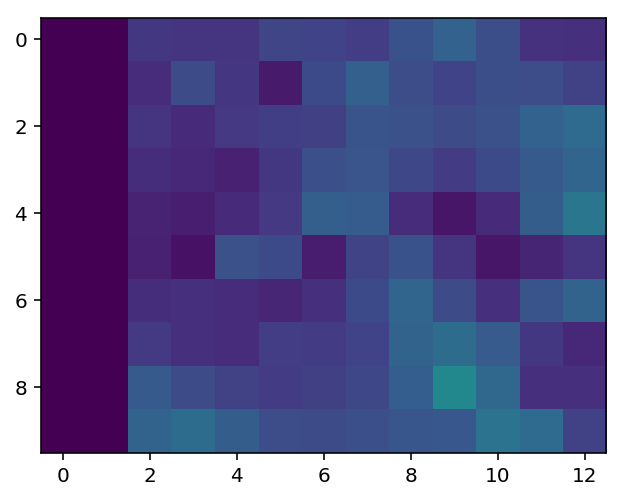

In [9]:
interactive(coarse_map,step=(1,50))

## Plotting strain profiles:

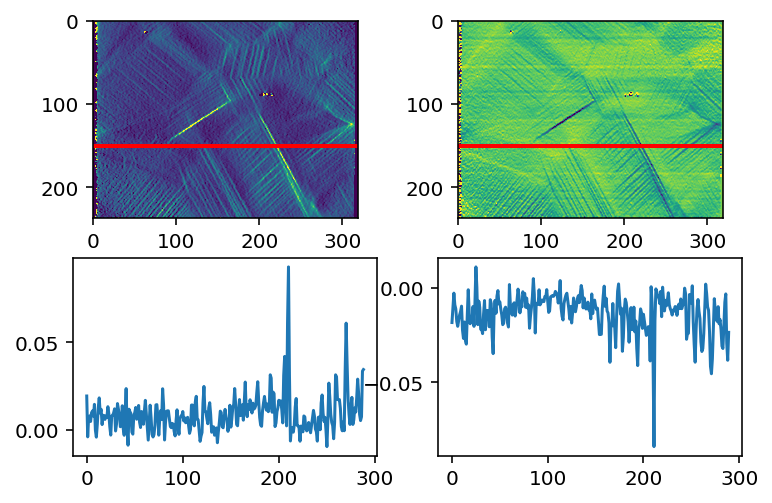

In [10]:
f,ax1=plt.subplots(2,2)
ax1.ravel()[0].imshow(def_map.f11,vmin=-0.01,vmax=0.08,interpolation='bilinear',cmap='viridis');
ax1.ravel()[1].imshow(def_map.f22,vmin=-0.08,vmax=0.02,interpolation='bilinear',cmap='viridis');
ax1.ravel()[0].axhline(150,linewidth=2, color='r')
ax1.ravel()[1].axhline(150,linewidth=2, color='r')
ax1.ravel()[2].plot(def_map.f11[150,10:-20])
ax1.ravel()[3].plot(def_map.f22[150,9:-20])


Nice script to plot a profile (hacked from stackexchange):

In [11]:
def plot_profile(def_map,start_point,end_point):
    y0, x0  = start_point[0], start_point[1] # These are in _pixel_ coordinates!!
    y1, x1 = end_point[0], end_point[1]
    profile_length=np.sqrt((y1-y0)**2+(x1-x0)**2)
    num = np.round(profile_length)
    x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

    # Extract the values along the line, using cubic interpolation
    zi = scipy.ndimage.map_coordinates(np.transpose(def_map), np.vstack((x,y)))
    plt.figure(figsize=(10,3))
    gs = gridspec.GridSpec(1, 2, height_ratios=[1]) 
    ax0=plt.subplot(gs[0])
    ax1=plt.subplot(gs[1])
    ax0.imshow(def_map,vmin=-0.00,vmax=0.05,interpolation='bilinear',cmap='viridis');
    ax0.plot([x0, x1], [y0, y1], 'rx-',lw=2);
    ax0.axis('image');
    ax1.plot(zi)
    ax1.axis('tight')


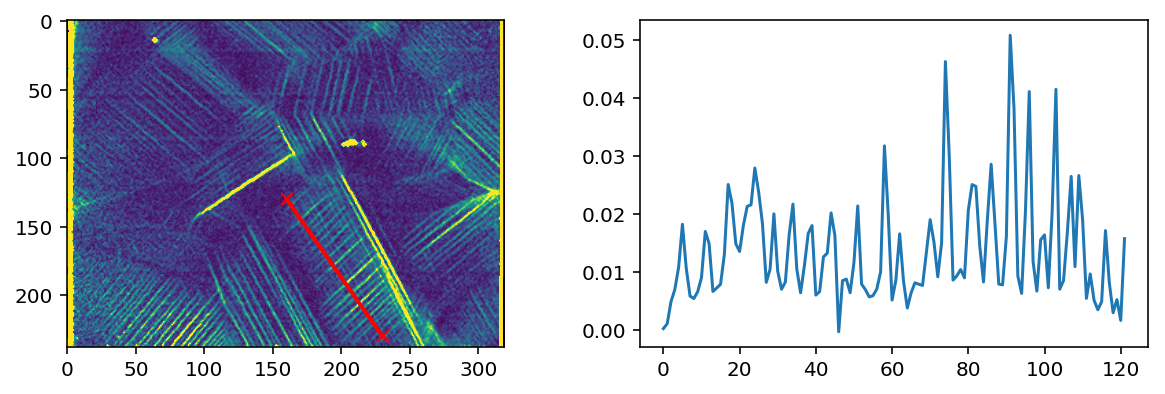

In [12]:
plot_profile(def_map.max_shear,[130,160],[230,230])

## Strain distributions

In [13]:
def def_hist(def_map,strain_range=(),plot='False'):
    if strain_range==():
        xs=np.histogram(def_map.flatten(),bins=100,normed=1);
        if plot==True:
            plt.hist(def_map.flatten(),bins=100,normed=1);
    else:
        xs=np.histogram(def_map.flatten(),bins=100,normed=1, range=strain_range);
        if plot==True:
            plt.hist(def_map.flatten(),bins=100,normed=1, range=strain_range);
    if plot==True:
        plt.xlabel('Deformation component');
        plt.ylabel('Normalized frequency');
    return(xs)

In [14]:
xs=def_hist(def_map.max_shear,(0.0,0.1),0)

In [15]:
def plot_hist_line(xs):
    yvals=xs[0]
    xvals=0.5*(xs[1][1:]+xs[1][:-1])
    plt.plot(xvals,yvals,'-o');
    plt.ylabel('Normalized frequency')
    plt.xlabel('$\gamma_{max}$')

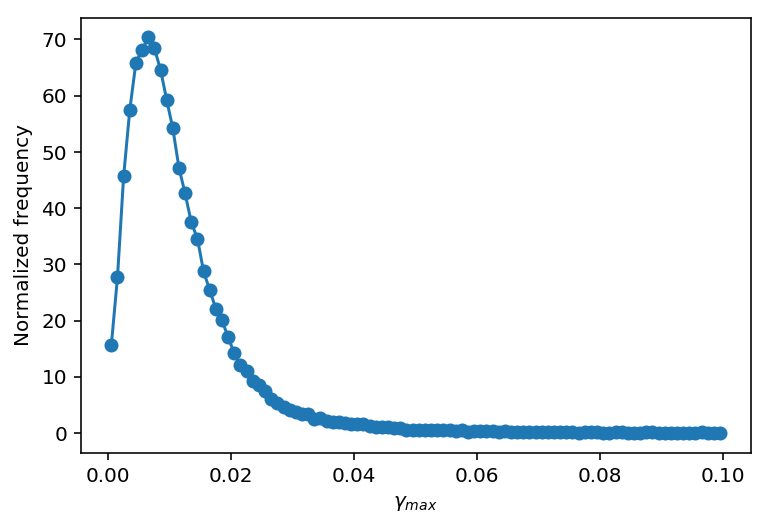

In [16]:
plt.figure()
plot_hist_line(xs)

## 2-point correlation

In [17]:
cropped=def_map.max_shear[:,10:-10]

In [18]:
def acorr_map(def_map,c_range=[]):
    acorr=(np.fft.fft2(def_map)*np.conjugate(np.fft.fft2(def_map)))
    ashift=np.fft.fftshift(acorr)
    corr_map=np.log(np.fft.fftshift((np.abs(np.fft.ifft2(ashift)))))
    if c_range==[]:
        plt.imshow(corr_map, interpolation='nearest', cmap='viridis');
    else:
        plt.imshow(corr_map, interpolation='nearest', cmap='viridis',
                   vmin=c_range[0], vmax=c_range[1]);
    return corr_map

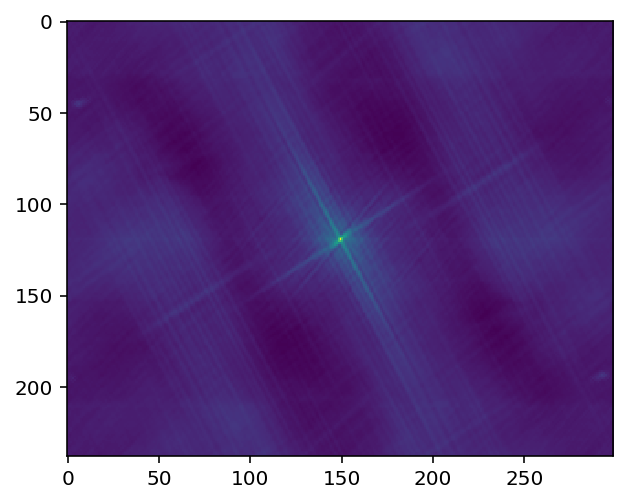

In [19]:
x=acorr_map(cropped)

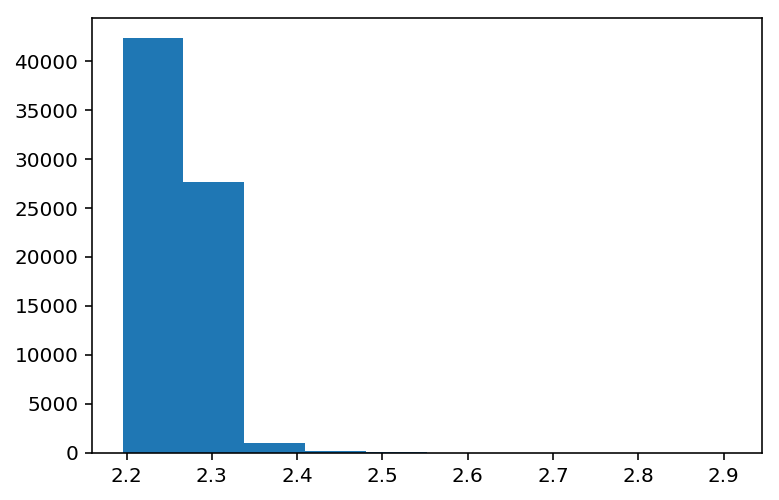

In [20]:
plt.figure()
plt.hist(x.ravel());

array([[ 2.2484752 ,  2.2535583 ,  2.25328953, ...,  2.25328953,
         2.2535583 ,  2.2484752 ],
       [ 2.24977151,  2.25165358,  2.25028169, ...,  2.25276284,
         2.25368153,  2.25080289],
       [ 2.25214686,  2.24840841,  2.24656879, ...,  2.24855294,
         2.2531226 ,  2.25334103],
       ..., 
       [ 2.25434896,  2.2507529 ,  2.24679115, ...,  2.24828812,
         2.246691  ,  2.25118447],
       [ 2.25334103,  2.2531226 ,  2.24855294, ...,  2.24656879,
         2.24840841,  2.25214686],
       [ 2.25080289,  2.25368153,  2.25276284, ...,  2.25028169,
         2.25165358,  2.24977151]])

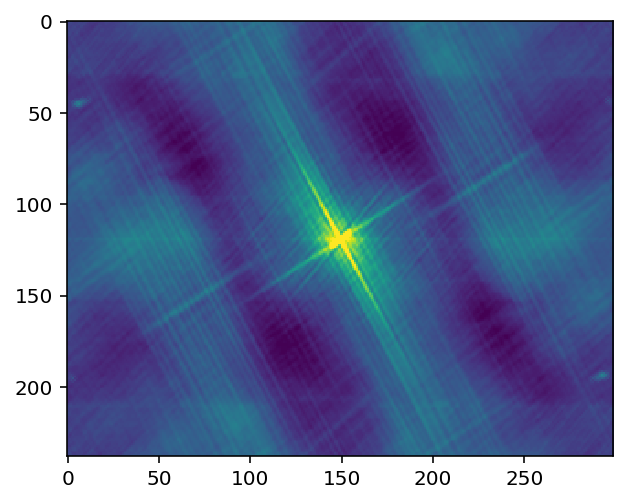

In [21]:
plt.figure()
acorr_map(cropped,[2.2,2.45])

We can also use FFT to filter the strain maps. Not sure if this is useful.

In [22]:
strain_map_fft=np.fft.fft2(cropped)
cut=50
lcut=int(np.shape(strain_map_fft)[0]/2-cut)
rcut=int(np.shape(strain_map_fft)[0]/2+cut)
tcut=int(np.shape(strain_map_fft)[1]/2-cut)
bcut=int(np.shape(strain_map_fft)[1]/2+cut)
strain_map_fft[lcut:rcut,tcut:bcut]=0

For an outside border:

In [31]:
strain_map_fft=np.fft.fft2(cropped)
cut=10
lcut=int(np.shape(strain_map_fft)[0]/2-cut)
rcut=int(np.shape(strain_map_fft)[0]/2+cut)
tcut=int(np.shape(strain_map_fft)[1]/2-cut)
bcut=int(np.shape(strain_map_fft)[1]/2+cut)
strain_map_fft[:lcut,:]=0
strain_map_fft[:,:tcut]=0
strain_map_fft[rcut:,:]=0
strain_map_fft[:,bcut:]=0

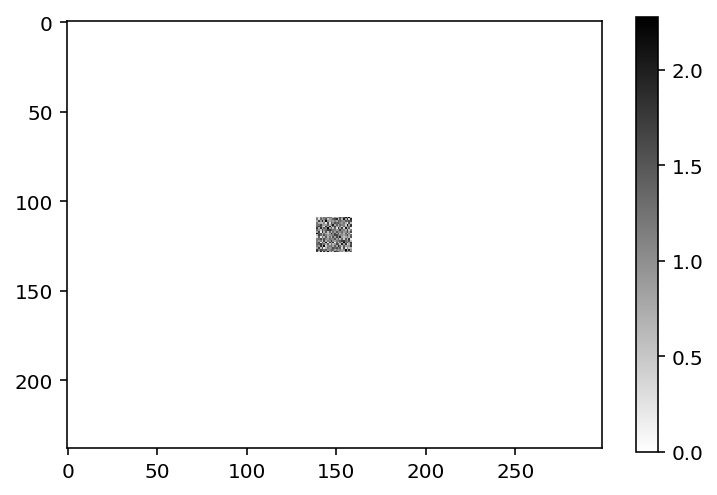

In [32]:
plt.imshow((np.abs(strain_map_fft)),cmap='binary')
plt.colorbar()

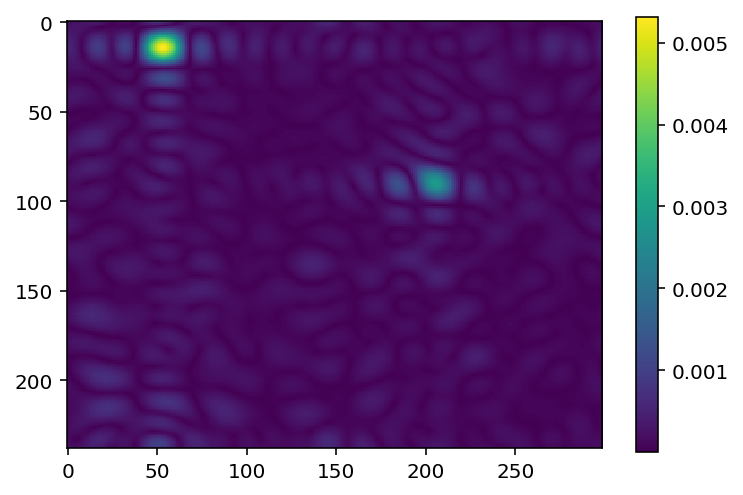

In [36]:
filt_image=np.abs(np.fft.ifft2(strain_map_fft))
plt.imshow(filt_image,cmap='viridis')
plt.colorbar()

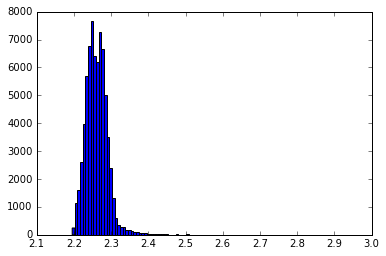

In [25]:
acorr=(np.fft.fft2(cropped)*np.conjugate(np.fft.fft2(cropped)))
ashift=np.fft.fftshift(acorr)
f1=np.fft.fftshift((np.abs(np.fft.ifft2(ashift))))
plt.hist(np.log(f1.flatten()), bins=100);

## Alternative data coarsening

In [26]:
cropped2=cropped[:210,:210]

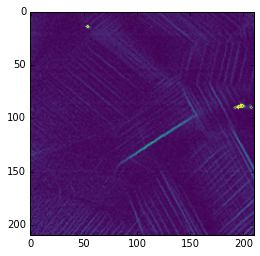

In [27]:
plt.imshow(cropped2,vmin=0,vmax=0.2,cmap='viridis', interpolation='bilinear');

In [28]:
np.shape(cropped2)

(210, 210)

In [29]:
big_view=np.reshape(cropped2,(210/30,30,210/30,30))

In [30]:
big3=big_view.mean(axis=3).mean(axis=1)

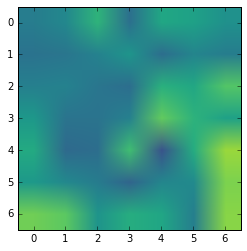

In [31]:
plt.imshow(big3,vmin=0,vmax=0.02,cmap='viridis', interpolation='bilinear')

Make a series of comparisons:

In [32]:
coarse_maps=[]
binnings=[30, 15, 5, 1]
for bins in binnings:
        big_view=np.reshape(cropped2,(210/bins,bins,210/bins,bins))
        big3=big_view.mean(axis=3).mean(axis=1)
        coarse_maps.append(big3)

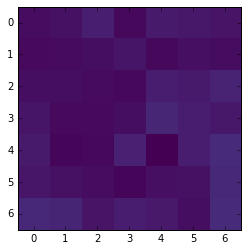

In [33]:
plt.figure()
plt.imshow(coarse_maps[0], vmax=0.1,cmap='viridis',interpolation='nearest')

/Users/joao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


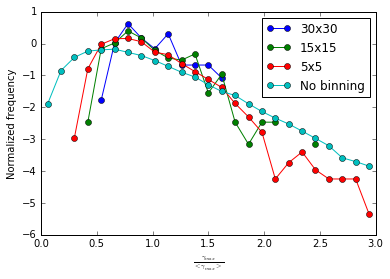

In [34]:
plt.figure()
xvals_list=[]
yvals_list=[]
for binMap in coarse_maps:
    xs=np.histogram(binMap.flatten()/binMap.mean(),bins=25, range=(0,3),normed='True')
    yvals=xs[0]
    xvals=0.5*(xs[1][1:]+xs[1][:-1])
    xvals_list.append(xvals)
    yvals_list.append(yvals)
    plt.plot((xvals),np.log(yvals),'-o');
    plt.legend(('30x30','15x15','5x5','No binning'),loc=0)
    plt.ylabel(r'Normalized frequency')
    plt.xlabel(r'$\frac{\gamma_{max}}{<\gamma_{max}>}$')

# Slip band orientation

For slip band orientation we can use the radon transform:

In [36]:
def sb_angle(shear_map,threshold=None,median_filter=None):
    if threshold != None:
        shear_map_filt=shear_map>threshold
        strain_title='Threshold: {:2.3f}'.format(threshold)
    else:
        shear_map_filt=shear_map
        strain_title='Shear strain: no threshold'
    
    if median_filter !=None:    
        shear_map_filt=medfilt(shear_map_filt,median_filter)
    
    sin_map = radon(shear_map_filt)
    profile_filt=np.max(sin_map,axis=0)
    
    plt.figure(figsize=(13,5))
    gs = gridspec.GridSpec(1, 3) 
    ax0=plt.subplot(gs[0])
    ax1=plt.subplot(gs[1])
    ax2=plt.subplot(gs[2])
    ax0.imshow(shear_map_filt,cmap='viridis')
    
    ax0.set_title(strain_title)
    ax1.imshow(sin_map,cmap='viridis')
    ax1.set_title('Sinogram')
    ax2.plot(profile_filt)
    ax2.set_title('Band angle distribution')
    ax2.set_xlabel(r'Angle in degrees')
    ax2.set_ylabel(r'Intensity')
    return profile_filt

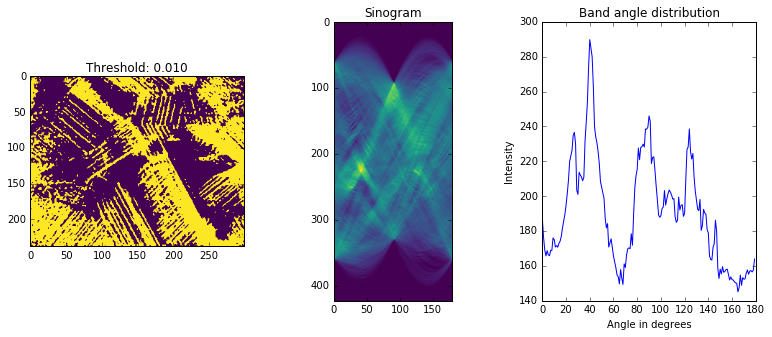

In [37]:
a=sb_angle(cropped,threshold=0.01,median_filter=3)

### Using Hough transform

In [38]:
from skimage.transform import (hough_line, hough_line_peaks)

In [81]:
def plot_hough_lines(def_map,threshold,n_peaks):
    h,theta,d = hough_line(def_map>threshold)
    rows, cols = cropped.shape
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,num_peaks=n_peaks)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
        plt.plot((0, cols), (y0, y1), '-r')
    plt.imshow(def_map>0.02,cmap='binary')
    plt.axis((0, cols, rows, 0))

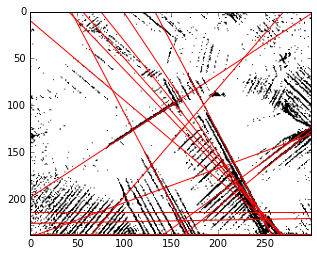

In [144]:
plot_hough_lines(cropped,0.02,15)

Not very successful, I think...

## Analysing individual grains

Here will will use an image of the microstructure to select different regions for analysis. First we import the grain boundary file:

In [51]:
gb_map=io.imread('../data/gbs.tiff')

In [52]:
np.shape(gb_map)

(368, 497, 3)

We need to convert it into grayscale:

In [53]:
gb=color.rgb2gray(gb_map)

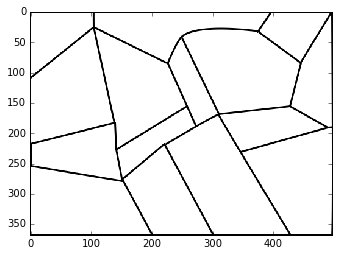

In [54]:
io.imshow(gb_map)

Next make it the same size as our map:

In [55]:
gb_resized=resize(gb,np.shape(cropped))

And then make it into a binary array:

In [56]:
gb_binary=(gb_resized<1)

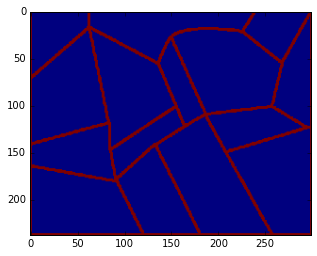

In [57]:
plt.imshow((gb_binary.astype(int)))

Next we need to label all the grains:

In [58]:
grain_labels=measure.label(gb_binary)

We can color the grains to see our grains:

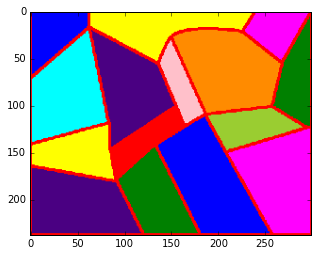

In [59]:
plt.imshow(color.label2rgb(grain_labels))

There are 15 grain labels but only 14 grains.

In [60]:
np.unique(grain_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

This is because label 0 represents the "grain boundaries". The function below masks the map using the grain labels:

In [61]:
def get_grain(def_map,glabels,glabel):
    grain=np.ma.array(def_map,mask=glabels!=glabel)
    return grain

In [62]:
grain5=get_grain(cropped,grain_labels,0)

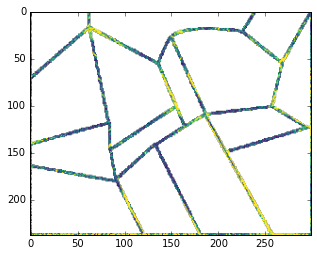

In [63]:
plt.figure()
plt.imshow(grain5,vmax=0.02,cmap='viridis')

Of course we can pick any other grain:

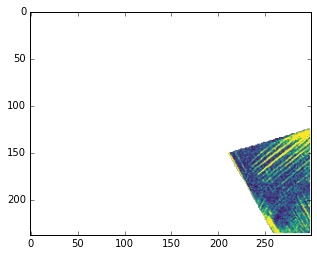

In [102]:
z=get_grain(cropped,grain_labels,13)
plt.imshow(z,vmax=0.025,cmap='viridis')

## Slip band orientation in one grain

Now that we can pick grains, we can plot strain distributions and measure band alignement on a grain to grain basis.

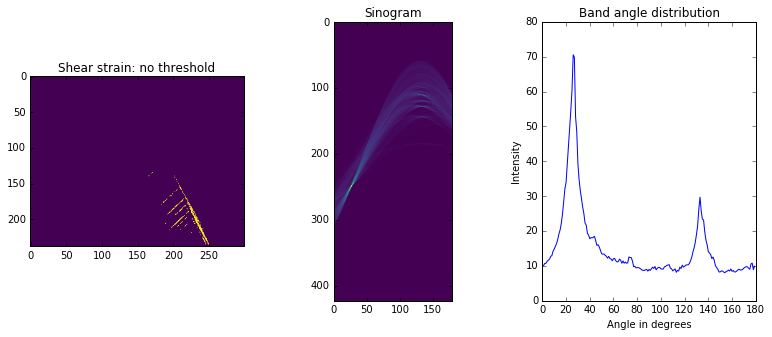

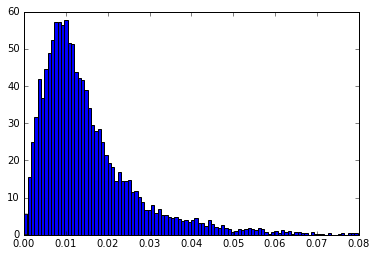

In [141]:
z=get_grain(cropped,grain_labels,11)
a=sb_angle(z.filled(0)>0.04)
plt.figure()
plt.hist(z.compressed(),bins=100,normed=True);

Using Hough transform:

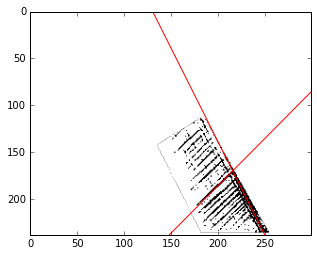

In [148]:
z=get_grain(cropped,grain_labels,11)
plot_hough_lines(z,0.035,3)